General transferable force fields, such as [Parsley](https://pubs.acs.org/doi/full/10.1021/acs.jctc.1c00571) or [Sage](https://openforcefield.org/force-fields/force-fields/),
allow us to rapidly parameterize small molecules covering vast amounts of chemical space for use in molecular dynamics simulations. However, with every force field comes the inherent assumption that
parameters fit to a set of representative molecules in a training set are transferable to any new molecules with similar chemistry.
Despite potential accuracy problems caused by poor transferability or discrete atom types the use 
of force fields in fields like drug discovery has been a massive success. Within the Open Force Field, we
use a unique method based on [SMARTS](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html) patterns to link
the force field parameters to chemical substructures, avoiding the use of atom types altogether, resulting in a more
[compact and manageable force field](https://doi.org/10.1021/acs.jctc.8b00640). While we have seen the number of unique
torsion parameters grow between versions of the force field to improve parameter performance the number of parameters
has remained very low when compared to other state-of-the-art force fields like OPLS3.


| Force Field | Number of unique torsion parameters |
|---|:----------------:|
|OpenFF-1.0.0| 157|
|OpenFF-1.2.0| 163|
|OpenFF-1.3.0| 167|
|OpenFF-2.0.0| 167|
|OPLS3|48,142|
|OPLSe|146,669|


This explosion in torsion parameters allows for high accuracy over a large area of chemical space with the types often becoming
very specific to certain chemistry. However, due to improved computer power and the reduced computational cost of generating
high accuracy reference data via the use of machine learned potentials such as [ANI](https://pubs.rsc.org/en/content/articlelanding/2017/SC/C6SC05720A),
a better solution may be to generate bespoke parameters on the fly. Enter :tada:[BespokeFit](https://github.com/openforcefield/bespoke-fit) :tada:
, BespokeFit is a python package which allows users to easily generate bespoke force field parameters for
their molecules under study which compliment the base OpenFF force field. Here we can think of BespokeFit as our general fitting
scheme which can be applied to new molecules to generate bespoke parameters on the fly for new unseen chemistry.

You may have seen [previously](https://openforcefield.org/community/news/science-updates/ff-training-example-2021-07-01/)
how BespokeFit, QCSubmit and QCFractal can be combined to fit general force fields and this time we are going to show
its other side and walk through an application to a simple molecule.

This will have the following structure:
- Building the general BespokeFit optimisation workflow
- Building and inspecting the molecule specific optimisation schema made from the general workflow
- Setup and run the BespokeExecutor
- Inspecting the fitted parameters

## Building the general workflow

BespokeFit aims to provide a reproducible parameter optimization workflow for SMIRNOFF based force fields.
As such normal BespokeFit execution starts with a general fitting workflow. This captures every process in the
workflow along with any adjustable settings such as how the reference data should be generated. The default workflow
is designed to optimize bespoke torsion parameters at the same level of theory as that used in the mainline openff force fields.
Here however, we will be starting with a blank workflow and building it up as we go.

First, we start with our optimization engine, which is an easy choice as we currently only support the fantastic
[ForceBalance](https://github.com/leeping/forcebalance) package (watch this space - optimizers are coming!).
Let's start by creating the ForceBalance optimization schema.

In [1]:
from openff.bespokefit.schema.optimizers import ForceBalanceSchema

# options for forcebalance
fb = ForceBalanceSchema()
fb.dict()

{'type': 'ForceBalance',
 'max_iterations': 10,
 'job_type': 'optimize',
 'penalty_type': 'L2',
 'step_convergence_threshold': 0.01,
 'objective_convergence_threshold': 0.01,
 'gradient_convergence_threshold': 0.01,
 'n_criteria': 2,
 'eigenvalue_lower_bound': 0.01,
 'finite_difference_h': 0.01,
 'penalty_additive': 1.0,
 'initial_trust_radius': -0.25,
 'minimum_trust_radius': 0.05,
 'error_tolerance': 1.0,
 'adaptive_factor': 0.2,
 'adaptive_damping': 1.0,
 'normalize_weights': False,
 'extras': {}}

As you can tell there are many options here and in some cases, it might not be clear what a valid input is. For example,
what other penalty types could we use?  :sparkles:[Pydantic](https://github.com/samuelcolvin/pydantic):sparkles: to the rescue,  pydantic
allows us to "_define how data should be in pure, canonical python_" and has run time validation to ensure our data is always correct.
What's more we even get a `schema` method for each model for free which fully describes the model with a short description for each field
and information on the acceptable inputs, it basically comes with its own documentation:book:. As such pydantic is used
extensively throughout BespokeFit to try and catch possible input errors ahead of run time, there is nothing worse than queuing up
a calculation for it to be instantly returned with an error on line one:man_facepalming:. Now the schema is
validated during assignment as we see below. First lets start by inspecting the optimizer schema using:

In [2]:
fb.schema()

{'title': 'ForceBalanceSchema',
 'description': 'A class containing the main ForceBalance optimizer settings to use during an\noptimization.\n\nPriors and target definitions are stored separately as part of an\n``OptimizationSchema``.',
 'type': 'object',
 'properties': {'type': {'title': 'Type',
   'default': 'ForceBalance',
   'enum': ['ForceBalance'],
   'type': 'string'},
  'max_iterations': {'title': 'Max Iterations',
   'description': 'The maximum number of optimization iterations to perform.',
   'default': 10,
   'exclusiveMinimum': 0,
   'type': 'integer'},
  'job_type': {'title': 'Job Type',
   'description': 'The mode to run force balance in.',
   'default': 'optimize',
   'enum': ['optimize'],
   'type': 'string'},
  'penalty_type': {'title': 'Penalty Type',
   'description': 'The penalty type.',
   'default': 'L2',
   'enum': ['L1', 'L2'],
   'type': 'string'},
  'step_convergence_threshold': {'title': 'Step Convergence Threshold',
   'description': 'The step size converge

We can now see that `penalty_type` only accepts the values L2 and L1 so lets try something else and see what happens.


In [3]:
#fb.penalty_type = "L3"

Nice, we get an informative error message before even running the workflow!


In [4]:
fb.penalty_type = "L1"

Now we can set it to L1 and start to build up our workflow and see what other pieces we might need.

{{< note >}}
By default the workflow model comes ready to fit bespoke torsion parameters using Open Force Field best practices and
default settings. Meaning only users who want absolute control over every setting (or developers showing of their work :grin:)
would need to do this manual set up .
{{< /note >}}


Lets start by creating our `BespokeWorkflowFactory` which acts as a fitting template for future optimizations
and add our `ForceBalanceSchema` optimizer settings. We can also remove all other defaults as we will go through them in
the next sections.


In [5]:
from openff.bespokefit.workflows import BespokeWorkflowFactory
from pprint import pprint

workflow = BespokeWorkflowFactory(
    fragmentation_engine=None, 
    optimizer=fb, 
    parameter_hyperparameters=[], 
    target_templates=[], 
    default_qc_specs=[]
)
pprint(workflow.dict())

{'default_qc_specs': [],
 'expand_torsion_terms': True,
 'fragmentation_engine': None,
 'generate_bespoke_terms': True,
 'initial_force_field': 'openff_unconstrained-1.3.0.offxml',
 'optimizer': {'adaptive_damping': 1.0,
               'adaptive_factor': 0.2,
               'eigenvalue_lower_bound': 0.01,
               'error_tolerance': 1.0,
               'extras': {},
               'finite_difference_h': 0.01,
               'gradient_convergence_threshold': 0.01,
               'initial_trust_radius': -0.25,
               'job_type': 'optimize',
               'max_iterations': 10,
               'minimum_trust_radius': 0.05,
               'n_criteria': 2,
               'normalize_weights': False,
               'objective_convergence_threshold': 0.01,
               'penalty_additive': 1.0,
               'penalty_type': 'L1',
               'step_convergence_threshold': 0.01,
               'type': 'ForceBalance'},
 'parameter_hyperparameters': [],
 'target_templates': [],
 

### Stage 1 Fragmentation

BespokeFit makes extensive use of the fantastic [openff-fragmenter](https://github.com/openforcefield/openff-fragmenter)
package where possible to reduce the cost of QM torsion drives as they can quickly become very expensive for large
drug-like molecules. Here we will add the WBO based fragmentation scheme to the pipeline with default settings. You can find
out more about how fragmenter works in a pre-print [here](https://www.biorxiv.org/content/10.1101/2020.08.27.270934v1).

In [6]:
from openff.fragmenter.fragment import WBOFragmenter

fragmenter = WBOFragmenter()
workflow.fragmentation_engine = fragmenter

By default, fragmenter will not fragment terminal rotatable bonds (such as methyl groups) as these are assumed to be
trivial and well described by our chosen force field. However, to keep things simple in our example we will be working with
`BrCO` and so we need to change this behaviour. Luckily BespokeFit/fragmenter allow us to overwrite this behaviour
by defining a SMARTS pattern (chemical substructure) which will be used to select the rotatable bonds.

In [7]:
workflow.target_torsion_smirks = ["[*]~[!$(*#*)&!D1:1]-,=;!@[!$(*#*)&!D1:2]~[*]"]



Here we have taken the default SMARTS pattern `[!#1]~[!$(*#*)&!D1:1]-,=;!@[!$(*#*)&!D1:2]~[!#1]` used to find torsions
and allowed the connecting atoms to the central bond to be hydrogens. This will ensure our simple molecule is processed
by the workflow, as without this change the workflow would reject the molecule as with no `rotatable` bonds there would be
no work to do :man_shrugging:.


### Stage 2 Reference Generation

As you may have guessed we are going to need some target reference data to optimize our force field parameters against
and that's where the target templates come in. These `target schemas` have two main functions:
- Describe the contribution to the total error function in the parameter optimization
- Generate specific reference data tasks that need to be computed in order to train with the target

In this case we will be using the `TorsionProfileTargetSchema` which requires a torsiondrive as input data. That is
a series of constrained geometry optimizations around the targeted rotatable bond, usually ranging from -180 -> 180 degrees
in 15 degree increments. There is slightly more to a torsiondrive than that and you can read more about how it works in the
[paper](https://doi.org/10.1063/5.0009232), but for now the main point is that we should get back a series of geometries
and energies to fit to. The actual torsion profile target then contributes the average RMSE between the QM and MM
energies at each geometry to the objective function and has a small number of settings exposed which we can see here.

In [8]:
from openff.bespokefit.schema.targets import TorsionProfileTargetSchema

target = TorsionProfileTargetSchema()
workflow.target_templates = [target, ]
pprint(target.dict())

{'attenuate_weights': True,
 'energy_cutoff': 10.0,
 'energy_denominator': 1.0,
 'extras': {},
 'reference_data': None,
 'type': 'TorsionProfile',
 'weight': 1.0}


You will also note that we passed the target in a list as the optimizer can use multiple targets to construct the objective
function, you can check out [Simons blog](https://openforcefield.org/community/news/science-updates/ff-training-example-2021-07-01/)
to see this in action.

{{< warning >}}
All target templates passed to the optimizer will be exercised at the same time as multi-stage fits are not yet supported.
{{< /warning >}}

We now need to tell BespokeFit what program, method and basis should be used to actually compute the reference tasks. As
we use the game changing [QCEngine](https://github.com/MolSSI/QCEngine) to power these calculations we have a wide range
of possibilities with one standard interface. BespokeFit defines the target specification using the `QCSpec` class from
QCSubmit which has built in validation to again catch any errors early in the process. Choosing a new QC task
specification for all tasks in the BespokeFit workflow is then as simple as:

In [9]:
from openff.qcsubmit.common_structures import QCSpec

xtb_spec = QCSpec(
    method="gfn2xtb", 
    basis=None, 
    program="xtb", 
    spec_name="xtb", 
    spec_description="gfn2xtb"
)

workflow.default_qc_specs = [xtb_spec]

To keep things moving quickly we have chosen to use a semi-empirical QC method, but by default BespokeFit will use the
same level of theory as that used to fit the main line force fields.


### Stage 3 Parameter Optimization

Finally, we have the parameter optimization stage and as we have already set up our optimizer using `ForceBalance` the last step
is to define some parameter hyperparameters. These tell BespokeFit which parameters we would like to fit and allows us to
define a prior to the parameter.

In [10]:
from openff.bespokefit.schema.smirnoff import  ProperTorsionHyperparameters

prior = ProperTorsionHyperparameters()
workflow.parameter_hyperparameters = [prior]

BespokeFit now knows we intend to optimize the torsion parameters to the target and with these final two settings we
can generate SMARTS patterns specific to the molecules that pass through the workflow and to fully expand
the torsion parameters to use all available k values.

In [11]:
workflow.generate_bespoke_terms = True
workflow.expand_torsion_terms = True

All that is left to do now is to save the workflow to file for later use, this is now our general workflow template which
we can apply to all molecules that pass into the BespokeFit pipeline. The serialized workflow is also a fantastic provenance
store, making it easy to tell exactly what settings were used to compute the parameters in a project.

In [12]:
# write to json
workflow.export_factory("workflow.json")
# or yaml
#workflow.export_factory("workflow.yaml")

## Building the Molecule Specific Schema

Now we can use our general fitting schema to build a molecule specific optimization schema.
This schema fully defines the optimization protocol that should be applied to the molecule including information
about the reference data generation tasks which BespokeFit will automatically perform locally for us. In this
example we will be using `BrCO`, so lets create the molecule using the `openff-toolkit`, save it to file for later and
create a `BespokeOptimizationSchema` for it using our workflow:

In [83]:
from openff.toolkit.topology import Molecule

target_molecule = Molecule.from_smiles("BrCO")
#target_molecule = Molecule.from_smiles("CC1=CC(OC2=CC(C(O)=O)=CC(OC)=C2)=CC(OC)=C1")
target_molecule.generate_conformers(n_conformers=1)
# write to file for later
target_molecule.to_file(file_path="test.sdf", file_format="sdf")
# make the specific schema
schema = workflow.optimization_schema_from_molecule(molecule=target_molecule)

If we now inspect the schema we find two main changes, i) the input molecule has been inserted, ii) some bespoke SMARTS patterns
have been created for the rotatable torsion identified in the molecule. These patterns and the initial force field values
can be easily viewed via:

In [14]:
schema.initial_parameter_values

{ProperTorsionSMIRKS(type='ProperTorsions', smirks='[#35H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#8H1X2x0!r+0A:3]-;!@[#1H0X1x0!r+0A:4]', attributes={'k2', 'k4', 'k1', 'k3'}): {'k2': Quantity(value=0, unit=kilocalorie/mole),
  'k4': Quantity(value=0, unit=kilocalorie/mole),
  'k1': Quantity(value=0, unit=kilocalorie/mole),
  'k3': Quantity(value=0.6985935181583, unit=kilocalorie/mole)},
 ProperTorsionSMIRKS(type='ProperTorsions', smirks='[#1H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#1H0X1x0!r+0A])(-;!@[#35H0X1x0!r+0A])-;!@[#8H1X2x0!r+0A:3]-;!@[#1H0X1x0!r+0A:4]', attributes={'k2', 'k4', 'k1', 'k3'}): {'k2': Quantity(value=0, unit=kilocalorie/mole),
  'k4': Quantity(value=0, unit=kilocalorie/mole),
  'k1': Quantity(value=0, unit=kilocalorie/mole),
  'k3': Quantity(value=0.6985935181583, unit=kilocalorie/mole)}}

You may also notice that as requested BespokeFit has expanded the k terms for each torsion parameter with each new term
set to zero by default. The non-zero values are then taken from the base force field to form our initial parameter values.
We can also use the `openff-toolkit` to query the molecule and identify the atoms matching these new patterns and
understand how the parameters will be applied to the molecule by visualizing the substructures.

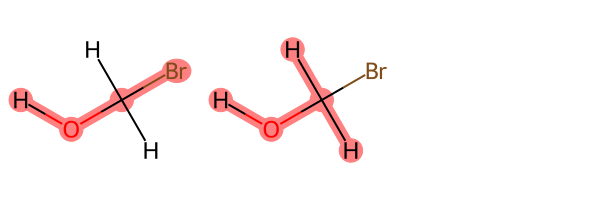

In [15]:
from rdkit.Chem import Draw, rdDepictor

parameters = schema.parameters
rd_mol = target_molecule.to_rdkit()
rdDepictor.Compute2DCoords(rd_mol)
rd_mols = []
atoms = []
for parameter in parameters:
    matches = target_molecule.chemical_environment_matches(query=parameter.smirks)
    flat_matches = [atom for match in matches for atom in match]
    rd_mols.append(rd_mol)
    atoms.append(flat_matches)

Draw.MolsToGridImage(rd_mols, highlightAtomLists=atoms)

We can see that BespokeFit has generated two bespoke SMARTS patterns, as determined by the
symmetry of the atoms around the central bond, covering all three torsion terms.

## Setting up the BespokeExecutor

In the last blog post we made use of the invaluable QCFractal infrastructure to compute our target data. Since then however,
we have been hard at work to offer a local execution pathway as an alternative reference generation method.
Here we still use QCEngine to execute the tasks, but spin up simple [Celery](https://docs.celeryproject.org/en/latest/index.html)
workers to perform the jobs. In fact the BespokeFit executor has been totally reworked to allow for a more flexible and scalable
fitting solution. Each of the major stages: fragmentation, reference generation and optimization are carried out
by dedicated workers which can be on the same local machine or distributed over multiple. Here we will be spinning up
the `BespokeExecutor` and three workers, one for each of the stages, in a single line! We will then submit our optimization
task via the RESTful API and let BespokeFit take care of the rest.



In [16]:
from openff.bespokefit.executor import BespokeExecutor, wait_until_complete
import os

# set keep files to true so we can view the results
os.environ["BEFLOW_KEEP_FILES"] = "True"

# launch the executor
with BespokeExecutor(
        n_fragmenter_workers=1,
        n_qc_compute_workers=1,
        n_optimizer_workers=1) as executor:
    # grab the task id and wait for the task to finish
    task = executor.submit(input_schema=schema)
    result = wait_until_complete(optimization_id=task.id)

Output()

[✓] fragmentation successful

Output()

[✓] qc-generation successful

Output()

[✓] optimization successful


worker: Warm shutdown (MainProcess)

worker: Warm shutdown (MainProcess)

worker: Warm shutdown (MainProcess)


In [23]:
result

CoordinatorGETResponse(self='/api/v1/tasks/13', id='13', stages=[CoordinatorGETStageStatus(type='fragmentation', status='success', error='null', results=[Link(self='/api/v1/fragmentations/ec394256-d3cb-42d3-8be5-48a7e9a58b6c', id='ec394256-d3cb-42d3-8be5-48a7e9a58b6c')]), CoordinatorGETStageStatus(type='qc-generation', status='success', error='[null]', results=[Link(self='/api/v1/qc-calcs/8addc192-1318-4623-9a3a-d910a61a53db', id='8addc192-1318-4623-9a3a-d910a61a53db')]), CoordinatorGETStageStatus(type='optimization', status='success', error='null', results=[Link(self='/api/v1/optimizations/f123a6db-cdb4-4e6c-aa2e-22c8faba390c', id='f123a6db-cdb4-4e6c-aa2e-22c8faba390c')])], results=BespokeOptimizationResults(type='bespoke', input_schema=BespokeOptimizationSchema(type='bespoke', id='f123a6db-cdb4-4e6c-aa2e-22c8faba390c', initial_force_field='<?xml version="1.0" encoding="utf-8"?>\n<SMIRNOFF version="0.3" aromaticity_model="OEAroModel_MDL">\n    <Author>The Open Force Field Initiative</

As our optimization task works through each stage you should see them complete with a tick and once all tasks are complete
the executor will shut down for us and clean up the workers as well! We can then check the result object to make sure
each stage did finish with no errors.

In [17]:
for stage in result.stages:
    print(stage.type, stage.status)

fragmentation success
qc-generation success
optimization success


## Inspecting the Optimized Parameters

Once the torsion optimization is complete a result schema is returned. The schema contains the final optimized
parameters that can be used with the `openff-toolkit` in workflows to parameterize molecules and set up systems in
OpenMM to run dynamics. The result schema also contains all provenance information which can help with reproducibility.

Now to convince ourselves that the optimization was successful and has lead to an improvement in the parameters - lets load
the final output from ForceBalance.

In [18]:
from IPython.display import IFrame

opt_id = f"bespoke-executor/{result.results.input_schema.id}/optimize.tmp/torsion-0/iter_0002/plot_torsion.pdf"

IFrame(
    opt_id, 
    width=900, 
    height=600)

BespokeFit has been successful as there is a clear improvement in the PES around this torsion with respect to the reference data.
We can also plot how the parameters have changed during optimization as the result schema stores the initial and
final torsion parameters.

In [204]:
#new torions
pprint(result.results.refit_parameter_values)


{ProperTorsionSMIRKS(type='ProperTorsions', smirks='[#35H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#8H1X2x0!r+0A:3]-;!@[#1H0X1x0!r+0A:4]', attributes={'k2', 'k4', 'k1', 'k3'}): {'k1': Quantity(value=-4.997143720405e-06, unit=kilocalorie/mole),
                                                                                                                                                                                                                         'k2': Quantity(value=-2.13301284101, unit=kilocalorie/mole),
                                                                                                                                                                                                                         'k3': Quantity(value=0.6985897609319, unit=kilocalorie/mole),
                                                                                                                                                                

In [198]:
minimalist = {torsion.smirks: {k: q._value for k, q in parameters.items()} for torsion, parameters in result.results.input_schema.initial_parameter_values.items()}
with open("my_file.json", "w") as f:
  json.dump(minimalist, f)

with open('my_file.json') as f:
    data = list(json.load(f).items())
#df = pd.DataFrame (list_name, columns = ['column_name'])
data

[('[#35H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#8H1X2x0!r+0A:3]-;!@[#1H0X1x0!r+0A:4]',
  {'k2': 0, 'k4': 0, 'k1': 0, 'k3': 0.6985935181583}),
 ('[#1H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#1H0X1x0!r+0A])(-;!@[#35H0X1x0!r+0A])-;!@[#8H1X2x0!r+0A:3]-;!@[#1H0X1x0!r+0A:4]',
  {'k2': 0, 'k4': 0, 'k1': 0, 'k3': 0.6985935181583})]

In [196]:
df['k_terms'] = df['k_terms'].str.replace("{","")
df

/var/folders/k4/mfxydxms5xb72hl9c7pmc8880000gp/T/ipykernel_75771/3618329598.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['k_terms'] = df['k_terms'].str.replace("{","")


,smirks,k_terms
0,[#35H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#...,NaN
1,[#1H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#1...,NaN


In [150]:
# Split the interaction fingerprint
fps = combined_df['IXFP_12'].str.split(' ', expand=True)

# Add a prefix to the fingerprint columns (ifp_0, ifp_1, ifp_3, etc.)
fps = fps.add_prefix('ifp_')

# Add the split up fingerprint data to the dataframe that contains all consistent/inconsistent poses
combined_df = pd.concat([combined_df, fps], axis=1)
# drop the concatenated ixp IXFP_12
combined_df = combined_df.drop(labels="IXFP_12", axis=1)

TypeError: keys must be str, int, float, bool or None, not ProperTorsionSMIRKS

In [130]:
with open("result.json", "w") as output:
    output.write(result.results.json())

In [134]:
data = json.load( open( "result.json" ) )
data.refit_parameter_values

AttributeError: 'dict' object has no attribute 'refit_parameter_values'

In [89]:
#initial torsions
result.results.input_schema.initial_parameter_values

{ProperTorsionSMIRKS(type='ProperTorsions', smirks='[#35H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#8H1X2x0!r+0A:3]-;!@[#1H0X1x0!r+0A:4]', attributes={'k2', 'k4', 'k1', 'k3'}): {'k2': Quantity(value=0, unit=kilocalorie/mole),
  'k4': Quantity(value=0, unit=kilocalorie/mole),
  'k1': Quantity(value=0, unit=kilocalorie/mole),
  'k3': Quantity(value=0.6985935181583, unit=kilocalorie/mole)},
 ProperTorsionSMIRKS(type='ProperTorsions', smirks='[#1H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#1H0X1x0!r+0A])(-;!@[#35H0X1x0!r+0A])-;!@[#8H1X2x0!r+0A:3]-;!@[#1H0X1x0!r+0A:4]', attributes={'k2', 'k4', 'k1', 'k3'}): {'k2': Quantity(value=0, unit=kilocalorie/mole),
  'k4': Quantity(value=0, unit=kilocalorie/mole),
  'k1': Quantity(value=0, unit=kilocalorie/mole),
  'k3': Quantity(value=0.6985935181583, unit=kilocalorie/mole)}}

In [200]:
parameter_data = []
for i, (parameter, initial_values) in enumerate(result.results.input_schema.initial_parameter_values.items()):
    for final_parameter, final_values in result.results.refit_parameter_values.items():
        if parameter.smirks == final_parameter.smirks:
            print(parameter.smirks)
            for term in range(1, 5):
                k_before = initial_values[f"k{term}"].value_in_unit(unit.kilocalorie_per_mole)
                k_after = final_values[f"k{term}"].value_in_unit(unit.kilocalorie_per_mole)
                parameter_data.append([f"smirks_{i}_k{term}", k_before, k_after, k_after - k_before])
parameter_data
# make a pandas dataframe
#df = pd.DataFrame(parameter_data, columns=["parameter", "before", "after", "change"])
#df

[#35H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#8H1X2x0!r+0A:3]-;!@[#1H0X1x0!r+0A:4]
[#1H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#1H0X1x0!r+0A])(-;!@[#35H0X1x0!r+0A])-;!@[#8H1X2x0!r+0A:3]-;!@[#1H0X1x0!r+0A:4]


[['smirks_0_k1', 0, -4.997143720405e-06, -4.997143720405e-06],
 ['smirks_0_k2', 0, -2.13301284101, -2.13301284101],
 ['smirks_0_k3', 0.6985935181583, 0.6985897609319, -3.7572264000029776e-06],
 ['smirks_0_k4', 0, 1.099622735499e-05, 1.099622735499e-05],
 ['smirks_1_k1', 0, 5.198546441732e-06, 5.198546441732e-06],
 ['smirks_1_k2', 0, 2.973054138758e-05, 2.973054138758e-05],
 ['smirks_1_k3', 0.6985935181583, 0.2117661114928, -0.48682740666549995],
 ['smirks_1_k4', 0, -0.05708729066233, -0.05708729066233]]

In [202]:
import pandas as pd
from simtk import unit

parameter_data = []
for i, (parameter, initial_values) in enumerate(result.results.input_schema.initial_parameter_values.items()):
    for final_parameter, final_values in result.results.refit_parameter_values.items():
        if parameter.smirks == final_parameter.smirks:
            for term in range(1, 5):
                k_before = initial_values[f"k{term}"].value_in_unit(unit.kilocalorie_per_mole)
                k_after = final_values[f"k{term}"].value_in_unit(unit.kilocalorie_per_mole)
                parameter_data.append([parameter.smirks, f"smirks_{i}_k{term}", k_before, k_after, k_after - k_before])

# make a pandas dataframe
df = pd.DataFrame(parameter_data, columns=["smirks", "parameter", "before", "after", "change"])
df

,smirks,parameter,before,after,change
0,[#35H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#...,smirks_0_k1,0.000000,-0.000005,-0.000005
1,[#35H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#...,smirks_0_k2,0.000000,-2.133013,-2.133013
2,[#35H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#...,smirks_0_k3,0.698594,0.698590,-0.000004
3,[#35H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#...,smirks_0_k4,0.000000,0.000011,0.000011
4,[#1H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#1...,smirks_1_k1,0.000000,0.000005,0.000005
5,[#1H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#1...,smirks_1_k2,0.000000,0.000030,0.000030
6,[#1H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#1...,smirks_1_k3,0.698594,0.211766,-0.486827
7,[#1H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#1...,smirks_1_k4,0.000000,-0.057087,-0.057087


In [205]:
pprint(result.results.refit_parameter_values)


{ProperTorsionSMIRKS(type='ProperTorsions', smirks='[#35H0X1x0!r+0A:1]-;!@[#6H2X4x0!r+0A:2](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#8H1X2x0!r+0A:3]-;!@[#1H0X1x0!r+0A:4]', attributes={'k2', 'k4', 'k1', 'k3'}): {'k1': Quantity(value=-4.997143720405e-06, unit=kilocalorie/mole),
                                                                                                                                                                                                                         'k2': Quantity(value=-2.13301284101, unit=kilocalorie/mole),
                                                                                                                                                                                                                         'k3': Quantity(value=0.6985897609319, unit=kilocalorie/mole),
                                                                                                                                                                

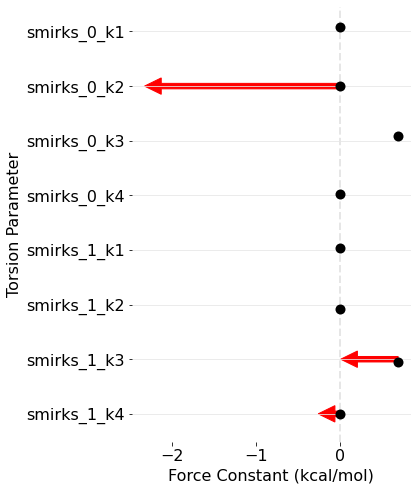

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rc('font', size=16)


ax = plt.figure(figsize=(5,8))
#add start points
ax = sns.stripplot(data=df, 
                   x='before', 
                   y='parameter', 
                   orient='h', 
                   order=df['parameter'], 
                   size=10, 
                   color='black')
ax.grid(axis='y', color='0.9') 
#add arrows to plot only if the parameter changed by more than 1e-3 kcal/mol
for i in range(len(df.index)):
    term = df.iloc[i]
    if abs(term["change"]) > 1e-3:
        if term["after"] > term["before"]:
            arrow_color = '#347768'
        elif term["after"] < term["before"]:
            arrow_color = 'red'
        else:
            arrow_color = 'black'
        ax.arrow(term["before"],        
                 i,                      
                 term["change"],    
                 0,                     
                 head_width=0.3,         
                 head_length=0.2,       
                 width=0.1,              
                 fc=arrow_color,            
                 ec=arrow_color)     
ax.axvline(x=0, color='0.9', ls='--', lw=2, zorder=0)
ax.set_xlabel('Force Constant (kcal/mol)')                               
ax.set_ylabel('Torsion Parameter')                         
sns.despine(left=True, bottom=True)

## Conclusion

To recap in this blog post we have:
- Created and configured a general BespokeFit workflow
- Built a molecule specific optimization schema
- Spun up the BespokeFitExecutor and workers
- Fragmented the molecule
- Automatically generated torsiondrive reference data using QCEngine
- Automatically generated bespoke SMARTS patterns for the molecule
- Optimized the torsion parameters using ForceBalance

Hopefully this demonstration has shown just how easy it is to set up a BespokeFit general fitting pipeline with a custom
configuration and train bespoke parameters to reference data generated on the fly from just a few imports.  Better yet
this whole process can now be routinely applied to new molecules from the CLI using our serialized workflow.

`openff-bespoke executor run --input BrCO.sdf --spec-file workflow.json`